In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast

In [2]:
def load_list_from_file(file_path):
    with open(file_path, 'r') as file:
        data_str = file.read()
    data = [json.loads(line) for line in data_str.splitlines()]
    return data


def write_list_to_file(file_path, data):
    data_str = [str(item) for item in data]  # Convert float values to strings
    with open(file_path, 'w') as file:
        file.write('\n'.join(data_str))
        
def load_or_generate_data(file1, file2, generation_func1, generation_func2, args1=(), kwargs1={}, args2=(), kwargs2={}):
    """
    Load data from files if they exist, or generate data using specified functions.
    
    :param file1: the file path to load the first data from
    :param file2: the file path to load the second data from
    :param generation_func1: the function to generate the first data if the file doesn't exist
    :param generation_func2: the function to generate the second data if the file doesn't exist
    :param args1: tuple containing positional arguments for the first generation function
    :param kwargs1: dict containing keyword arguments for the first generation function
    :param args2: tuple containing positional arguments for the second generation function
    :param kwargs2: dict containing keyword arguments for the second generation function
    :return: a tuple containing the two datasets
    """
    
    if os.path.exists(file1) and os.path.exists(file2):
        data1 = load_list_from_file(file1)
        data2 = load_list_from_file(file2)
        print('Files exist!')
    else:
        print('Files do not exist, generating data...')
        data1 = generation_func1(*args1, **kwargs1)
        data2 = generation_func2(*args2, **kwargs2)
        
        if not os.path.exists(file1):
            write_list_to_file(file1, data1)
            
        if not os.path.exists(file2):
            write_list_to_file(file2, data2)
    
    return data1, data2

def draw_graph(H, figsize=(8, 6), k=0.1, draw_self_loops=True, config={}):
    plt.figure(figsize=figsize)
    
    pos = nx.spring_layout(H, k=k)
    node_color = config.get('node_color', 'lightblue')
    node_size = config.get('node_size', 500)
    normal_edge_color = config.get('normal_edge_color', 'gray')
    normal_edge_width = config.get('normal_edge_width', 2.0)
    edge_style = config.get('edge_style', 'solid')
    self_loop_color = config.get('self_loop_color', 'red')
    title = config.get('title', '')

    # Get the weights of self-loops from adjacency matrix
    self_loop_weights = nx.to_numpy_array(H).diagonal()
    max_weight = max(self_loop_weights) if self_loop_weights.any() else 1

    # Set width relative to the max weight for self-loops
    self_loop_widths = {node: 4.0 * weight / max_weight for node, weight in zip(H.nodes, self_loop_weights)}

    # Prepare color and width for edges
    edge_colors = []
    edge_widths = []
    for u, v in H.edges():
        if u == v and draw_self_loops:  # self-loop
            edge_colors.append(self_loop_color)
            edge_widths.append(self_loop_widths[u])
        else:  # regular edge
            edge_colors.append(normal_edge_color)
            edge_widths.append(normal_edge_width)

    # Draw nodes
    nx.draw_networkx_nodes(H, pos, node_color=node_color, node_size=node_size)

    # Draw edges
    for edge, color, width in zip(H.edges(), edge_colors, edge_widths):
        if not (edge[0] == edge[1] and not draw_self_loops):  # Do not draw self-loops if draw_self_loops is False
            nx.draw_networkx_edges(H, pos, edgelist=[edge], edge_color=color, width=width, style=edge_style)

    # Draw labels
    nx.draw_networkx_labels(H, pos)

    plt.axis('off')
    plt.title(title)
    plt.show()

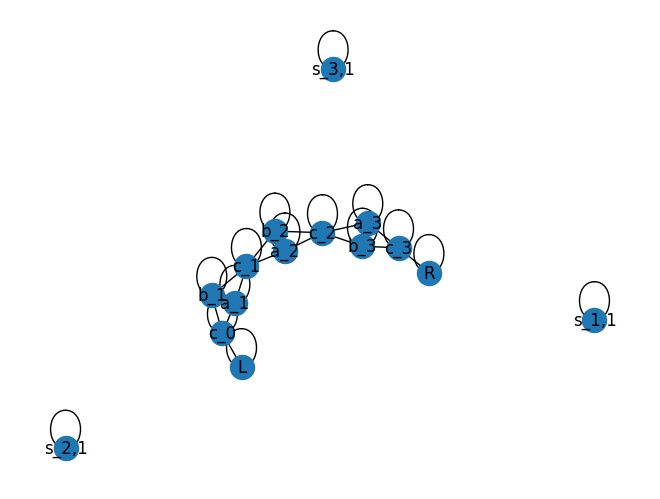

In [17]:
def create_graph(l, k):
    V = ["L", "R", "s_0"] + [f"s_{i},{j}" for i in range(1, l+1) for j in range(3)]
    H = nx.Graph()  # Graph is undirected

    H.add_nodes_from(V)
    mapping = {"L": "L", "R": "R", "s_0": "c_0"}
    mapping.update({f"s_{i},{k}": f"c_{i}" for i in range(1, l+1)})
    mapping.update({f"s_{i},{(k+1)%3}": f"b_{i}" for i in range(1, l+1)})
    mapping.update({f"s_{i},{(k+2)%3}": f"a_{i}" for i in range(1, l+1)})

    H = nx.relabel_nodes(H, mapping)

    # add edges
    H.add_edge("L", "c_0")
    for i in range(1, l):
        H.add_edge(f"c_{i-1}", f"a_{i}")
        H.add_edge(f"c_{i-1}", f"b_{i}")
        H.add_edge(f"a_{i}", f"c_{i}")
        H.add_edge(f"b_{i}", f"c_{i}")
    H.add_edge(f"c_{l-1}", f"a_{l}")
    H.add_edge(f"c_{l-1}", f"b_{l}")
    H.add_edge(f"a_{l}", f"c_{l}")
    H.add_edge(f"b_{l}", f"c_{l}")
    H.add_edge(f"c_{l}", "R")

    # add self-loops
    for node in H.nodes():
        H.add_edge(node, node, weight=H.degree(node))

    return H

def draw_graph(H):
    pos = nx.spring_layout(H)
    nx.draw(H, pos, with_labels=True)
    plt.show()

def create_evolving_graph(n, epsilon):
    sequence = []
    for i in range(int(n**(1-epsilon))):
        for j in range(3):
            sequence.append(create_graph(2*n, j))
    return sequence

def draw_evolving_graph(sequence):
    for i, H in enumerate(sequence):
        plt.figure(i)
        draw_graph(H)

epsilon = 0.5
n = 3
l = n
k = 7
# sequence = create_evolving_graph(n, epsilon)
# draw_evolving_graph(sequence)
h = create_graph(l,k)
draw_graph(h)

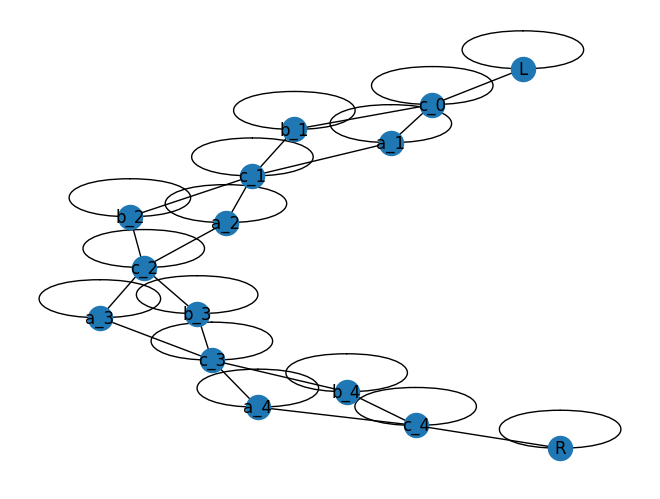

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

def create_graph(l, k):
    V = ["L", "R", "s_0"] + [f"s_{i},{j}" for i in range(1, l+1) for j in range(3)]
    H = nx.Graph()  # Graph is undirected

    H.add_nodes_from(V)
    mapping = {"L": "L", "R": "R", "s_0": "c_0"}
    mapping.update({f"s_{i},{k}": f"c_{i}" for i in range(1, l+1)})
    mapping.update({f"s_{i},{(k+1)%3}": f"b_{i}" for i in range(1, l+1)})
    mapping.update({f"s_{i},{(k+2)%3}": f"a_{i}" for i in range(1, l+1)})

    H = nx.relabel_nodes(H, mapping)

    # add edges
    H.add_edge("L", "c_0")
    for i in range(1, l):
        H.add_edge(f"c_{i-1}", f"a_{i}")
        H.add_edge(f"c_{i-1}", f"b_{i}")
        H.add_edge(f"a_{i}", f"c_{i}")
        H.add_edge(f"b_{i}", f"c_{i}")
    H.add_edge(f"c_{l-1}", f"a_{l}")
    H.add_edge(f"c_{l-1}", f"b_{l}")
    H.add_edge(f"a_{l}", f"c_{l}")
    H.add_edge(f"b_{l}", f"c_{l}")
    H.add_edge(f"c_{l}", "R")

    # add self-loops
    for node in H.nodes():
        H.add_edge(node, node, weight=H.degree(node))

    return H

def draw_graph(H):
    pos = nx.spring_layout(H)
    nx.draw(H, pos, with_labels=True)
    plt.show()

# example usage
draw_graph(create_graph(4, 0))


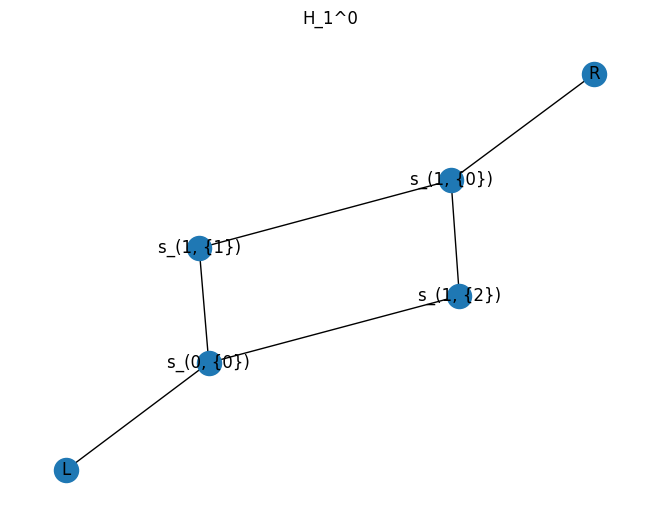

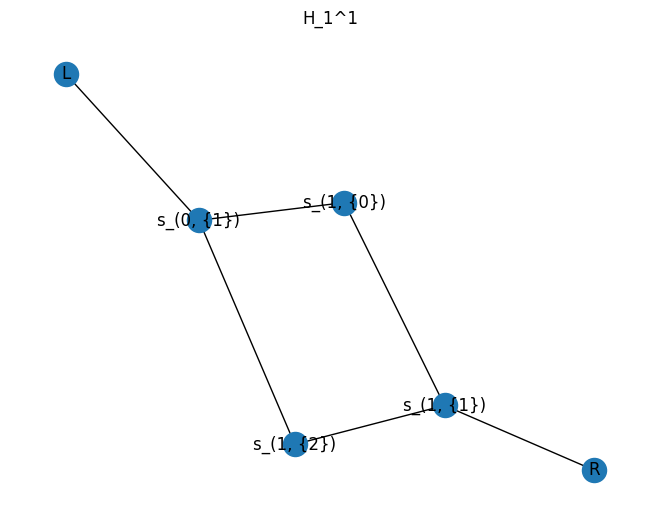

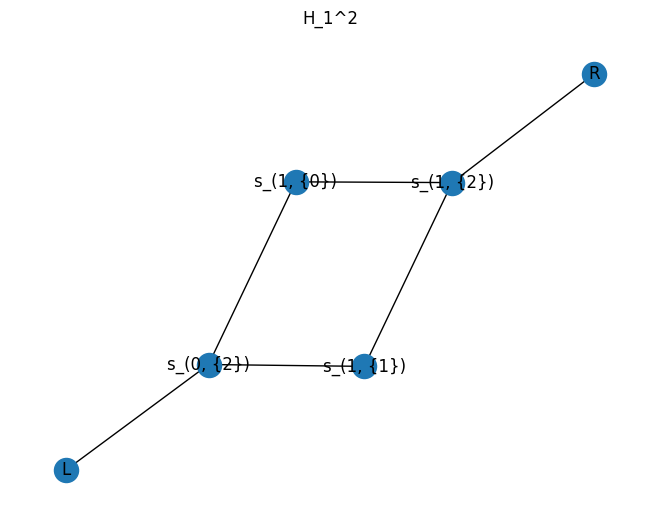

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

def create_graph(l, k):
    H = nx.MultiGraph()  # Multigraph is used to support multiple edges between the same nodes

    # add nodes and edges
    H.add_edge("L", f"s_{0, {k%3}}")
    for i in range(1, l+1):
        H.add_edge(f"s_{i-1, {k%3}}", f"s_{i, {(k+2)%3}}")
        H.add_edge(f"s_{i-1, {k%3}}", f"s_{i, {(k+1)%3}}")
        H.add_edge(f"s_{i, {(k+2)%3}}", f"s_{i, {k%3}}")
        H.add_edge(f"s_{i, {(k+1)%3}}", f"s_{i, {k%3}}")
    H.add_edge(f"s_{l, {k%3}}", "R")

    # add self-loops
    # for node in H.nodes():
    #     for _ in range(H.degree(node)):
    #         H.add_edge(node, node)  # multiple self-loops, each with weight 1

    return H

def plot_graph(H, title):
    plt.figure()
    nx.draw(H, with_labels=True)
    plt.title(title)

# Create and plot the graphs
H_1_0 = create_graph(1, 0)
plot_graph(H_1_0, "H_1^0")

H_1_1 = create_graph(1, 1)
plot_graph(H_1_1, "H_1^1")

H_1_2 = create_graph(1, 2)
plot_graph(H_1_2, "H_1^2")

plt.show()


 s_0,0 ===> c_0 ----- L

Edges for i = 1
s_0,0 ===> c_0 ----- c_1 <=== s_1,2
s_0,0 ===> c_0 ----- b_1 <=== s_1,1
s_1,2 ===> c_1 ----- a_1 <=== s_1,0
s_1,1 ===> b_1 ----- a_1 <=== s_1,0

Edges for i = 2
s_1,0 ===> a_1 ----- c_2 <=== s_2,2
s_1,0 ===> a_1 ----- b_2 <=== s_2,1
s_2,2 ===> c_2 ----- a_2 <=== s_2,0
s_2,1 ===> b_2 ----- a_2 <=== s_2,0
s_0,0 ----- R 		 a_2 ----- R
s_0,0 ===> a_2 ----- R    <=== R


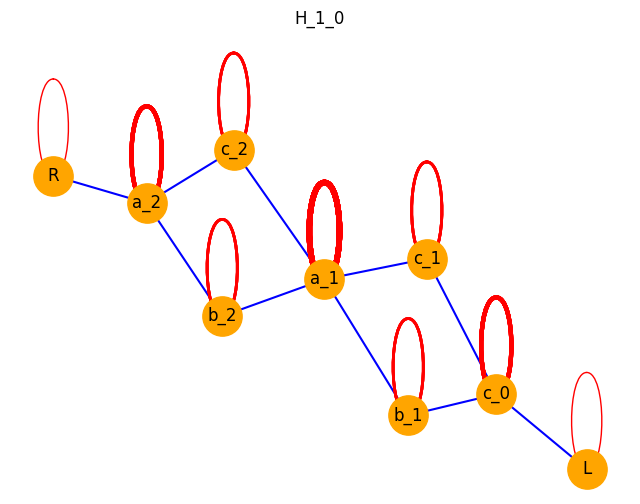

 s_0,1 ===> c_0 ----- L

Edges for i = 1
s_0,1 ===> c_0 ----- b_1 <=== s_1,0
s_0,1 ===> c_0 ----- a_1 <=== s_1,2
s_1,0 ===> b_1 ----- c_1 <=== s_1,1
s_1,2 ===> a_1 ----- c_1 <=== s_1,1

Edges for i = 2
s_1,1 ===> c_1 ----- b_2 <=== s_2,0
s_1,1 ===> c_1 ----- a_2 <=== s_2,2
s_2,0 ===> b_2 ----- c_2 <=== s_2,1
s_2,2 ===> a_2 ----- c_2 <=== s_2,1
s_0,1 ----- R 		 c_2 ----- R
s_0,1 ===> c_2 ----- R    <=== R


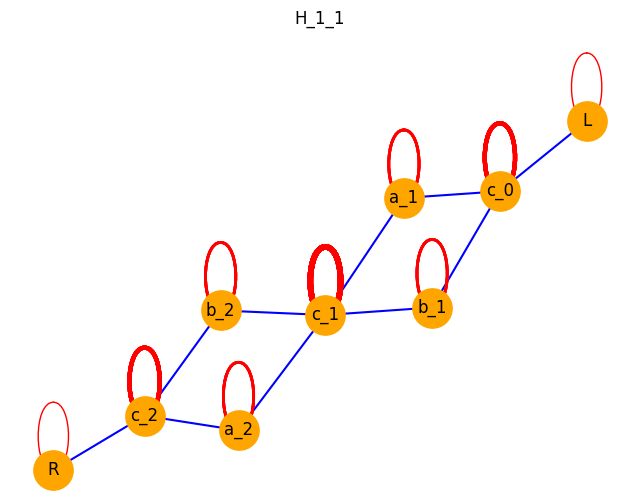

 s_0,2 ===> c_0 ----- L

Edges for i = 1
s_0,2 ===> c_0 ----- a_1 <=== s_1,1
s_0,2 ===> c_0 ----- c_1 <=== s_1,0
s_1,1 ===> a_1 ----- b_1 <=== s_1,2
s_1,0 ===> c_1 ----- b_1 <=== s_1,2

Edges for i = 2
s_1,2 ===> b_1 ----- a_2 <=== s_2,1
s_1,2 ===> b_1 ----- c_2 <=== s_2,0
s_2,1 ===> a_2 ----- b_2 <=== s_2,2
s_2,0 ===> c_2 ----- b_2 <=== s_2,2
s_0,2 ----- R 		 b_2 ----- R
s_0,2 ===> b_2 ----- R    <=== R


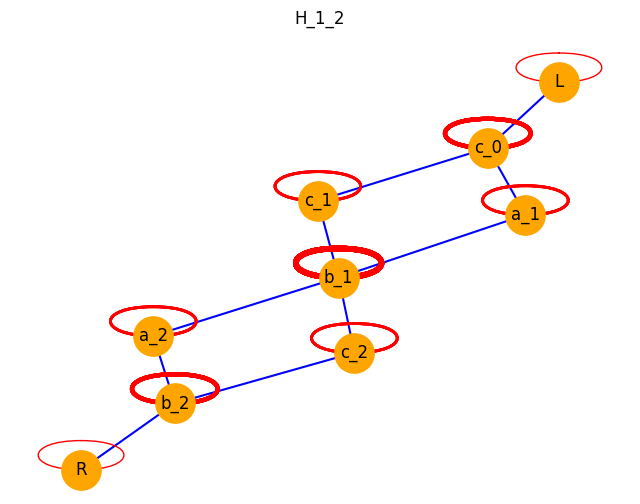

In [27]:
def create_vertex_mapping(l, k):
    #generate the characters 'a', 'b', 'c' cyclically based on the values of j and k.
    #The number 97 is the ASCII value for the character 'a', and (j+k)%3 generates thenumbers 0, 1, 2 in a cyclic manner.
    mapping = {f"s_{i},{j}": f"{chr(97 + (j+k)%3)}_{i}" for i in range(1, l+1) for j in range(3)}  # start range from 1 for i
    mapping.update({f"s_0,{j}": "c_0" for j in range(3)})  # handle s_0 separately
    mapping["L"] = "L"
    mapping["R"] = "R"
    return mapping

def create_graph(l, k):
    H = nx.MultiGraph()  # Multigraph is used to support multiple edges between the same nodes

    # get vertex mapping
    mapping = create_vertex_mapping(l, k)

    # add nodes and edges
    H.add_edge(mapping["L"], mapping[f"s_{0},{k%3}"])
    print(f' {f"s_{0},{k%3}"} ===> {mapping[f"s_{0},{k%3}"]} ----- {mapping[f"L"]}')
    for i in range(1, l+1):
        print(f'\nEdges for i = {i}')
        H.add_edge(mapping[f"s_{i-1},{k%3}"], mapping[f"s_{i},{(k+2)%3}"])
        print(f'{f"s_{i-1},{k%3}"} ===> {mapping[f"s_{i-1},{k%3}"]} ----- {mapping[f"s_{i},{(k+2)%3}"]} <=== {f"s_{i},{(k+2)%3}"}')
        
        H.add_edge(mapping[f"s_{i-1},{k%3}"], mapping[f"s_{i},{(k+1)%3}"])
        # print(f'{f"s_{i-1},{k%3}"} ----- {f"s_{i},{(k+1)%3}"}\t {mapping[f"s_{i-1},{k%3}"]} ----- {mapping[f"s_{i},{(k+1)%3}"]}')
        print(f'{f"s_{i-1},{k%3}"} ===> {mapping[f"s_{i-1},{k%3}"]} ----- {mapping[f"s_{i},{(k+1)%3}"]} <=== {f"s_{i},{(k+1)%3}"}')
        
        
        H.add_edge(mapping[f"s_{i},{(k+2)%3}"], mapping[f"s_{i},{k%3}"])
        # print(f'{f"s_{i},{(k+2)%3}"} ----- {f"s_{i},{k%3}"}\t {mapping[f"s_{i},{(k+2)%3}"]} ----- {mapping[f"s_{i},{k%3}"]}')
        print(f'{f"s_{i},{(k+2)%3}"} ===> {mapping[f"s_{i},{(k+2)%3}"]} ----- {mapping[f"s_{i},{k%3}"]} <=== {f"s_{i},{k%3}"}')
        
        
        H.add_edge(mapping[f"s_{i},{(k+1)%3}"], mapping[f"s_{i},{k%3}"])
        # print(f'{f"s_{i},{(k+1)%3}"} ----- {f"s_{i},{k%3}"}\t {mapping[f"s_{i},{(k+1)%3}"]} ----- {mapping[f"s_{i},{k%3}"]}')
        print(f'{f"s_{i},{(k+1)%3}"} ===> {mapping[f"s_{i},{(k+1)%3}"]} ----- {mapping[f"s_{i},{k%3}"]} <=== {f"s_{i},{k%3}"}')

    H.add_edge(mapping[f"s_{l},{k%3}"], mapping["R"])
    print(f'{f"s_{0},{k%3}"} ----- R \t\t {mapping[f"s_{l},{k%3}"]} ----- {mapping[f"R"]}')
    print(f'{f"s_{0},{k%3}"} ===> {mapping[f"s_{l},{k%3}"]} ----- R    <=== {mapping[f"R"]}')
    

    # add self-loops
    for node in H.nodes():
        for _ in range(H.degree(node)):
            H.add_edge(node, node)  # multiple self-loops, each with weight 1
            
    return H

def plot_graph(H, title):
    plt.figure()
    nx.draw(H, with_labels=True)
    plt.title(title)
    
config = {
    'figsize': (10, 8),
    'k': 0.2,
    'draw_self_loops': False,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_1_0'
}

config1 = {
    'figsize': (10, 8),
    'k': 0.2,
    'draw_self_loops': False,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_1_1'
}

config2 = {
    'figsize': (10, 8),
    'k': 0.2,
    'draw_self_loops': False,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_1_2'
}

H_1_0 = create_graph(2, 0)
draw_graph(H_1_0, config=config)

H_1_1 = create_graph(2, 1)
draw_graph(H_1_1, config=config1)



H_1_2 = create_graph(2, 2)
draw_graph(H_1_2, config=config2)

plt.show()

# Diff version

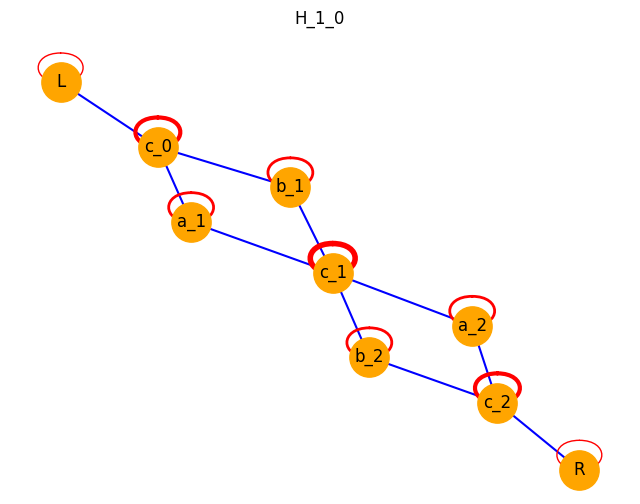

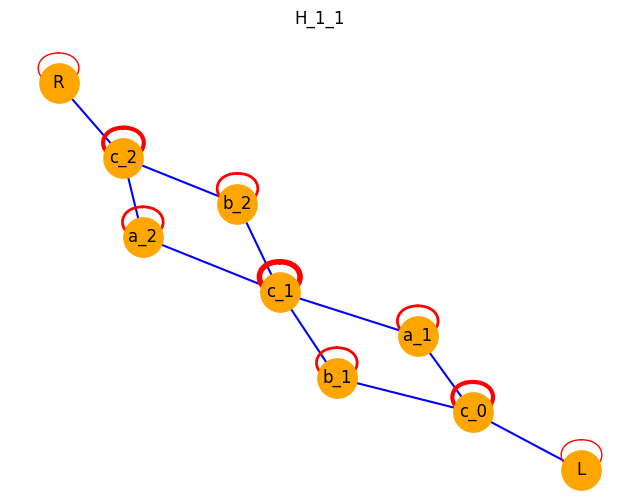

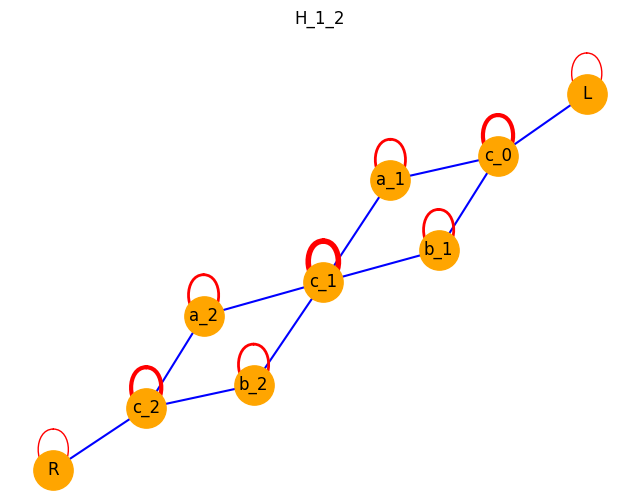

In [42]:
def create_graph(l, k):
    V = ["L", "R", "s_0"] + [f"s_{i},{j}" for i in range(1, l+1) for j in range(3)]
    H = nx.Graph()  # Graph is undirected

    H.add_nodes_from(V)
    mapping = {"L": "L", "R": "R", "s_0": "c_0"}
    mapping.update({f"s_{i},{k}": f"c_{i}" for i in range(1, l+1)})
    mapping.update({f"s_{i},{(k+1)%3}": f"b_{i}" for i in range(1, l+1)})
    mapping.update({f"s_{i},{(k+2)%3}": f"a_{i}" for i in range(1, l+1)})

    H = nx.relabel_nodes(H, mapping)

    # add edges
    H.add_edge("L", "c_0")
    for i in range(1, l):
        H.add_edge(f"c_{i-1}", f"a_{i}")
        H.add_edge(f"c_{i-1}", f"b_{i}")
        H.add_edge(f"a_{i}", f"c_{i}")
        H.add_edge(f"b_{i}", f"c_{i}")
    H.add_edge(f"c_{l-1}", f"a_{l}")
    H.add_edge(f"c_{l-1}", f"b_{l}")
    H.add_edge(f"a_{l}", f"c_{l}")
    H.add_edge(f"b_{l}", f"c_{l}")
    H.add_edge(f"c_{l}", "R")

    # add self-loops
    for node in H.nodes():
        H.add_edge(node, node, weight=H.degree(node))

    return H

config = {
    'figsize': (10, 8),
    'k': 0.2,
    'draw_self_loops': False,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_1_0'
}

config1 = {
    'figsize': (10, 8),
    'k': 0.2,
    'draw_self_loops': False,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_1_1'
}

config2 = {
    'figsize': (10, 8),
    'k': 0.2,
    'draw_self_loops': False,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_1_2'
}

H_1_0 = create_graph(2, 0)
draw_graph(H_1_0, config=config)

H_1_1 = create_graph(2, 1)
draw_graph(H_1_1, config=config1)



H_1_2 = create_graph(2, 2)
draw_graph(H_1_2, config=config2)

plt.show()